Task 2.2 - Climate-Related Topic Modelling (25%)

Step 1: Dataset Preparation

In [2]:
# these are all the libraries required for the task 
# importing all the required libraries
import pandas as pd
import nltk, re, spacy
from nltk.corpus import stopwords
from gensim.models import LdaModel, TfidfModel, Word2Vec, HdpModel
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# loading the train dataset in df
df = pd.read_csv("train_dataset.csv")
# number of the documents in the train dataset
# we are only using the text column and dorpping the label as it is not required for the Topic modelling task
print(df.columns)
df = df.dropna(subset=["text"])
texts = df["text"].tolist()
print("Number of documents in Train Dataset:", len(texts))

Index(['text', 'label'], dtype='object')
Number of documents in Train Dataset: 800


#### NLP Data Preprocessing

nltk.word_tokenize()

Stopword removal

Length filtering 

Lowercasing

Lemmatization using WordNetLemmatizer

In [4]:
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# for the lemmatizer and the stopwords
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # tokenizing the data usinf the word_tokenize func
    tokens = word_tokenize(text)
    
    # lowercasing and remove the short and longer tokens in the text 3 <= len(token) <= 15
    # removed the punctuations and the numbers using isalpha()
    clean_tokens = [
        lemmatizer.lemmatize(token.lower())  
        for token in tokens
        if token.isalpha()                       
        and 3 <= len(token) <= 15                
        and token.lower() not in stop_words      
    ]
    return clean_tokens


[nltk_data] Downloading package punkt to C:\Users\pc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\pc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\pc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Applied the preprocessing on the text
df["tokens"] = df["text"].apply(preprocess)
df[["text", "tokens"]].head()

,text,tokens
0,"In July 2020, BlackRock provided comments to t...","[july, blackrock, provided, comment, departmen..."
1,Climate change strategy Climate risks the Comm...,"[climate, change, strategy, climate, risk, com..."
2,In order to achieve Environmental Future Visio...,"[order, achieve, environmental, future, vision..."
3,In addition to providing the facility with ste...,"[addition, providing, facility, steam, needed,..."
4,Paper and waste: the BBVAsinplastico project (...,"[paper, waste, bbvasinplastico, project, http,..."


Creating a Dictionary and Bag-of-Words (BoW) Corpus

In [6]:
from gensim.corpora import Dictionary

# creating the dictionaruy of the tokens
dictionary = Dictionary(df["tokens"])

# printing the no. of unique tokens 
print(f"Number of unique tokens: {len(dictionary)}")
print(dictionary)  
# This is to covert the dictionary into bag-of-words representation
bow_corpus = [dictionary.doc2bow(doc) for doc in df["tokens"]]

#  Sample vector of the bag of words representation
print("Bag of Words vector:", bow_corpus[0])

Number of unique tokens: 4614
Dictionary<4614 unique tokens: ['ability', 'aimed', 'blackrock', 'burden', 'comment']...>
Bag of Words vector: [(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 3), (10, 1), (11, 2), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 3), (28, 1), (29, 1), (30, 4), (31, 1), (32, 2), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1)]


Topic Modelling - Latent Dirichlet Allocation (LDA)

In [7]:
from gensim.models import LdaMulticore
import multiprocessing
# we used 3 topics for the task as we need need the to identify topics that are associated with climate-related risks
# opportunity as we already know the topics risk, neutral and opportunity using 3 topics here 
lda_model = LdaMulticore(
    corpus=bow_corpus,
    num_topics=3,
    id2word=dictionary,
    passes=10,
    iterations=100,
    random_state=42,
    workers=multiprocessing.cpu_count()  
)
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx}:\n{topic}\n")

Topic 0:
0.015*"energy" + 0.013*"emission" + 0.009*"carbon" + 0.008*"project" + 0.007*"million" + 0.007*"target" + 0.007*"gas" + 0.006*"climate" + 0.006*"year" + 0.006*"also"

Topic 1:
0.034*"risk" + 0.022*"climate" + 0.019*"change" + 0.012*"impact" + 0.008*"environmental" + 0.007*"may" + 0.007*"physical" + 0.006*"investment" + 0.006*"business" + 0.006*"emission"

Topic 2:
0.009*"carbon" + 0.008*"risk" + 0.008*"investment" + 0.008*"company" + 0.008*"energy" + 0.008*"project" + 0.007*"climate" + 0.007*"portfolio" + 0.006*"power" + 0.006*"asset"



In [8]:
# we are printing the head() of the LDA model to chekc the risk and opportunities labelling
# with the probability of each topic in the label
def get_dominant_topics(lda_model, corpus, texts):
    dominant_topics = []
    for i, row in enumerate(lda_model[corpus]):
        sorted_row = sorted(row, key=lambda x: x[1], reverse=True)
        topic_num = sorted_row[0][0]
        topic_prob = sorted_row[0][1]
        dominant_topics.append((i, topic_num, topic_prob, texts[i]))
    return pd.DataFrame(dominant_topics, columns=["Document NO.", "Dominant Topic", "Topic Probability", "Text"])

topic_doc_df = get_dominant_topics(lda_model, bow_corpus, df["text"])

# We are assigning the topics labels here and checking the topic modelling reuslts for risk and opportunity mainly
topic_labels = {
    0: "Opportunity",
    1: "Risk",
    2: "Neutral"
}
topic_doc_df["Topic Label"] = topic_doc_df["Dominant Topic"].map(topic_labels)
topic_doc_df.head()

,Document NO.,Dominant Topic,Topic Probability,Text,Topic Label
0,0,1,0.986788,"In July 2020, BlackRock provided comments to t...",Risk
1,1,1,0.984337,Climate change strategy Climate risks the Comm...,Risk
2,2,0,0.738583,In order to achieve Environmental Future Visio...,Opportunity
3,3,1,0.596280,In addition to providing the facility with ste...,Risk
4,4,0,0.981066,Paper and waste: the BBVAsinplastico project (...,Opportunity


C:\Users\pc\AppData\Local\Temp\ipykernel_31104\3214212915.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=topic_counts, x="Topic_Label", y="Num_Documents", palette="coolwarm")


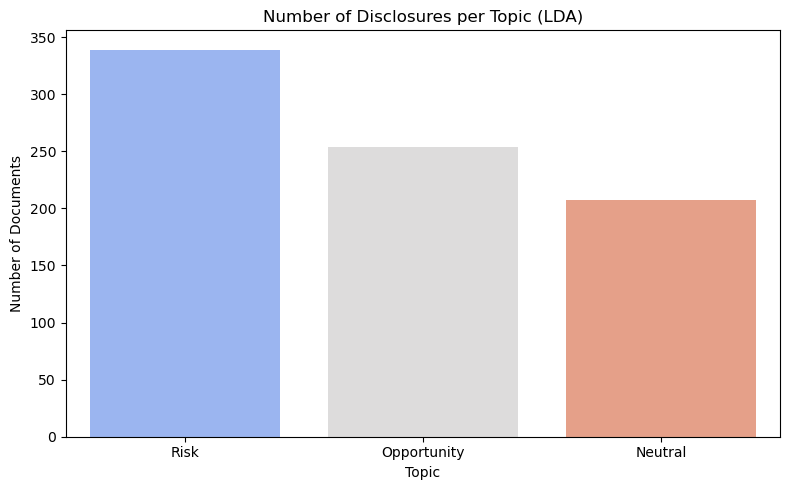

In [9]:
# We are also aiming to plot the labels of the topics and the number of documents in each topic
topic_counts = topic_doc_df["Topic Label"].value_counts().reset_index()
topic_counts.columns = ["Topic_Label", "Num_Documents"]
plt.figure(figsize=(8, 5))
sns.barplot(data=topic_counts, x="Topic_Label", y="Num_Documents", palette="coolwarm")
plt.title("Number of Disclosures per Topic (LDA)")
plt.xlabel("Topic")
plt.ylabel("Number of Documents")
plt.tight_layout()
plt.show()

LDA modelling on the unseen data - validation data

In [10]:
# loading and preprocessing the validation datset and using it as unsee data
val_df = pd.read_csv("val_dataset.csv")
val_df.dropna(subset=["text"], inplace=True)
val_df["tokens"] = val_df["text"].apply(preprocess)
# same dictionary and bag-of-words representation for this unseen/ validation dataset
val_corpus = [dictionary.doc2bow(doc) for doc in val_df["tokens"]]

# Again the same function for the unseen data
def get_val_topic_mapping(lda_model, val_corpus, val_texts):
    result = []
    for i, doc_bow in enumerate(val_corpus):
        topic_dist = lda_model[doc_bow]
        sorted_topics = sorted(topic_dist, key=lambda x: x[1], reverse=True)
        dominant_topic = sorted_topics[0][0]
        topic_prob = sorted_topics[0][1]
        result.append((i, dominant_topic, topic_prob, val_texts[i]))
    return pd.DataFrame(result, columns=["Document NO.", "Dominant Topic", "Topic Probrobability", "Text"])
val_topic_df = get_val_topic_mapping(lda_model, val_corpus, val_df["text"])

topic_labels = {
    0: "Opportunity",
    1: "Risk",
    2: "Neutral"
}
val_topic_df["Topic Label"] = val_topic_df["Dominant Topic"].map(topic_labels)
val_topic_df.head()

,Document NO.,Dominant Topic,Topic Probrobability,Text,Topic Label
0,0,1,0.623097,10 Representative Concentration Pathways (RCP)...,Risk
1,1,1,0.969502,"- For the first time, in 2019 and with the hel...",Risk
2,2,0,0.897507,IFC is targeting new growth areas in energy st...,Opportunity
3,3,0,0.712584,In addition to reductions in our vending and c...,Opportunity
4,4,2,0.800618,"However, the topic involves other areas of the...",Neutral


In [11]:
# Number of doccumnets which is classified as risk, neutral and opportunity
val_topic_counts = val_topic_df["Topic Label"].value_counts().reset_index()
print(val_topic_counts)

   Topic Label  count
0         Risk     84
1  Opportunity     84
2      Neutral     32


C:\Users\pc\AppData\Local\Temp\ipykernel_31104\3845649541.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=val_topic_counts, x="Topic Label", y="Num Documents", palette="pastel")


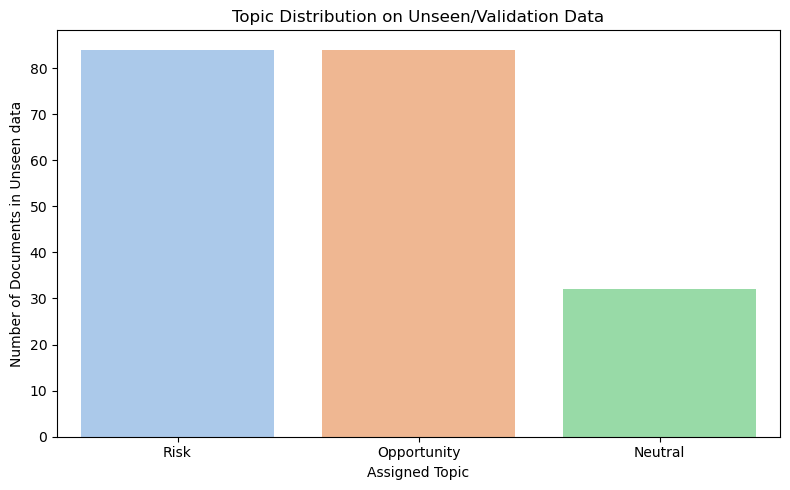

In [12]:
# plotting a bar plot which shows how many documents are classified in each topic
val_topic_counts = val_topic_df["Topic Label"].value_counts().reset_index()
val_topic_counts.columns = ["Topic Label", "Num Documents"]
plt.figure(figsize=(8, 5))
sns.barplot(data=val_topic_counts, x="Topic Label", y="Num Documents", palette="pastel")
plt.title("Topic Distribution on Unseen/Validation Data")
plt.xlabel("Assigned Topic")
plt.ylabel("Number of Documents in Unseen data")
plt.tight_layout()
plt.show()

In [13]:
# below we are printing the complete text of 3 documents in the val dataset
# with all the values of the topic ditribustion and probability and topic label predicted

def get_detailed_validation_topics(lda_model, val_corpus, val_texts):
    for i, doc_bow in enumerate(val_corpus):
        topic_dist = lda_model[doc_bow]
        sorted_topics = sorted(topic_dist, key=lambda x: x[1], reverse=True)
        dominant_topic = sorted_topics[0][0]
        topic_label = topic_labels[dominant_topic]
        print(f"\nDocument {i}:")
        print(f"TEXT:\n{val_texts[i]}")
        print("\nTOPIC DISTRIBUTION:")
        for topic_id, prob in topic_dist:
            print(f"Topic {topic_id} ({topic_labels[topic_id]}): {prob:.3f}")
        print(f"Dominant Topic: Topic {dominant_topic} ({topic_label})")

get_detailed_validation_topics(lda_model, val_corpus, val_df["text"])


Document 0:
TEXT:
10 Representative Concentration Pathways (RCP) scenarios are named based on the hypothetical radiative forcing level (the portion of energy transmitted to the earth that is trapped within its atmosphere) of the earth at the end of the century.

TOPIC DISTRIBUTION:
Topic 0 (Opportunity): 0.030
Topic 1 (Risk): 0.623
Topic 2 (Neutral): 0.347
Dominant Topic: Topic 1 (Risk)

Document 1:
TEXT:
- For the first time, in 2019 and with the help of external specialists, BNP Paribas performed an assessment, on a sample of clients in its portfolio, of physical risks covering the consequences of climate change (extreme weather events) on the assets of Group clients.

TOPIC DISTRIBUTION:
Topic 0 (Opportunity): 0.015
Topic 1 (Risk): 0.970
Topic 2 (Neutral): 0.016
Dominant Topic: Topic 1 (Risk)

Document 2:
TEXT:
IFC is targeting new growth areas in energy storage, transportation logistics, distributed renewables, off-shore wind, nature-based solutions, and carbon capture and storage

In [16]:
import random
from IPython.display import display, HTML
# here we are picking a random document and displaying the percentaage of the 
# topic distribution and finlly predicted topic label fr the text
rand_index = random.randint(0, len(val_df) - 1)
raw_text = val_df["text"].iloc[rand_index]
tokens = val_df["tokens"].iloc[rand_index]
bow_vec = dictionary.doc2bow(tokens)
topic_dist = lda_model[bow_vec]
sorted_topics = sorted(topic_dist, key=lambda x: x[1], reverse=True)
dominant_topic = sorted_topics[0][0]
topic_label = topic_labels[dominant_topic]

# here i have used scrollable to display the output 
# Output print
output_html = f"""
<div style="max-height: 500px; overflow-y: scroll; font-family: monospace; white-space: pre-wrap; border:1px solid #ccc; padding:10px;">
RANDOM DOCUMENT (Index {rand_index})
RAW TEXT:
{raw_text}
BAG-OF-WORDS REPRESENTATION:
{chr(10).join([f"{dictionary[idx]}: {count}" for idx, count in bow_vec])}
TOPIC DISTRIBUTION:
{chr(10).join([f"Topic {tid} ({topic_labels[tid]}): {dict(topic_dist).get(tid, 0.0):.3%}" for tid in range(3)])}
DOMINANT TOPIC: Topic {dominant_topic} ({topic_label})
</div>
"""
display(HTML(output_html))


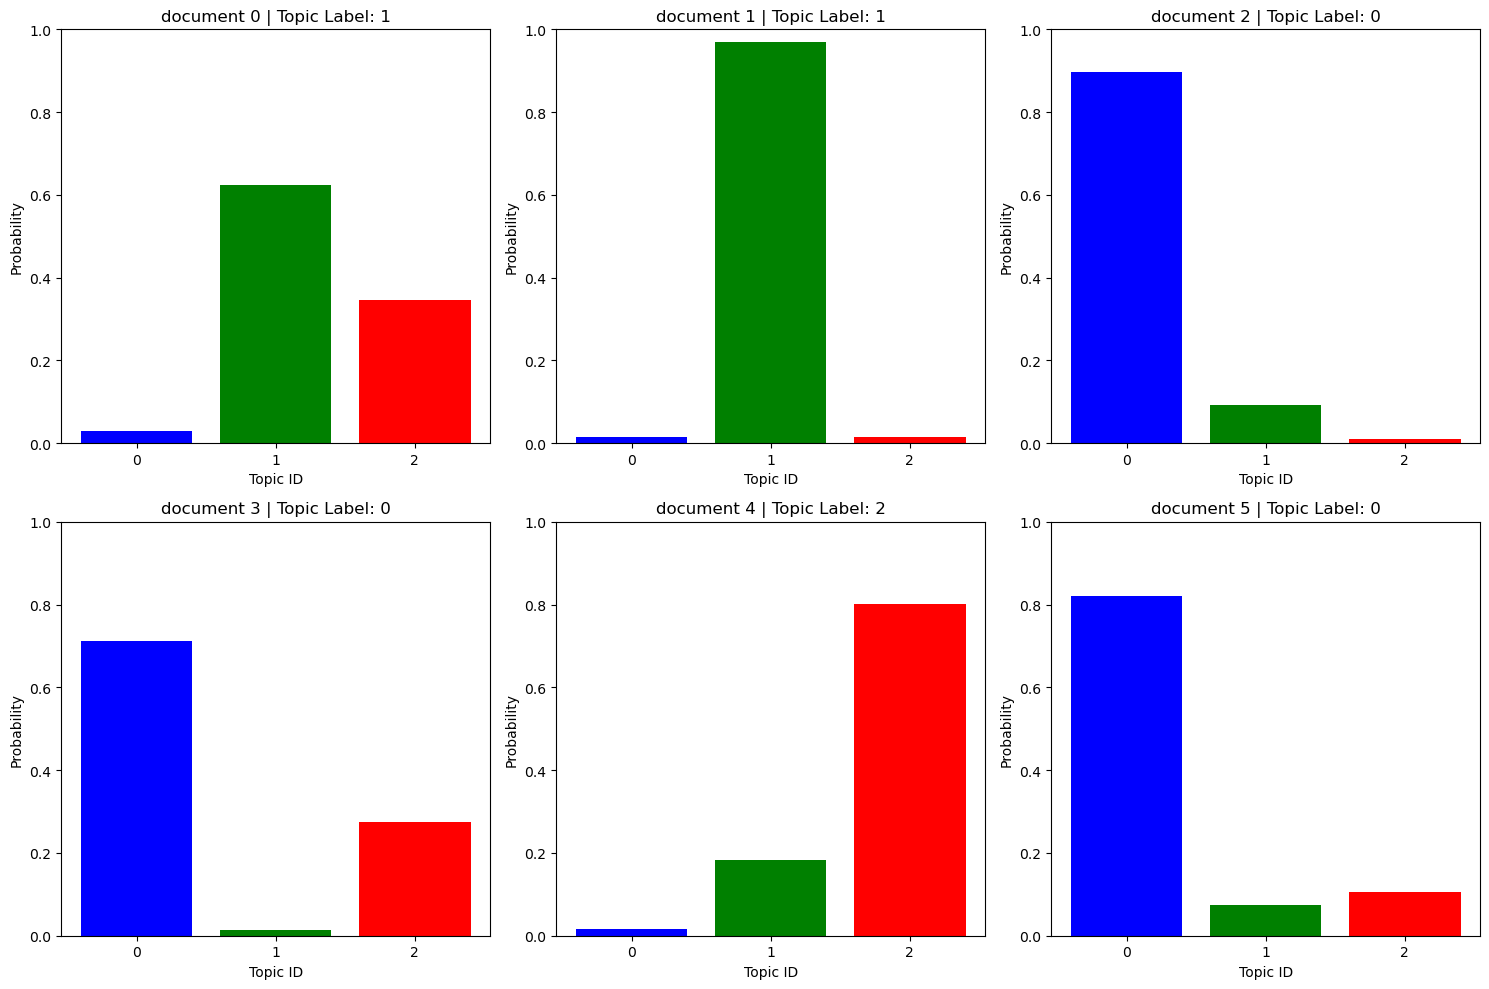

In [17]:
# from the lab - 3 lectures implementation printing the plot to visually see the topic dominance for the documents 
import matplotlib.pyplot as plt
import numpy as np
from gensim.matutils import sparse2full

colours = ['blue', 'green', 'red']

# this func converts the sparse list to dense vector (length = number of topics)
def convert_theta_sparse_to_dense(theta_d_sparse, num_topics=3):
    theta_d = np.zeros(num_topics)
    active_topics, probs = zip(*theta_d_sparse) if theta_d_sparse else ([], [])
    for i, topic in enumerate(active_topics):
        if topic < num_topics:
            theta_d[topic] = probs[i]
    return theta_d

# plotting the topic distribution for first n documents
def plot_topic_distributions_for_validation(lda_model, val_corpus, num_docs=9, num_topics=3):
    plt.figure(figsize=(15, 10))
    for d in range(min(num_docs, len(val_corpus))):
        theta_sparse = lda_model[val_corpus[d]]
        theta_dense = convert_theta_sparse_to_dense(theta_sparse, num_topics)

        plt.subplot(int(np.ceil(num_docs / 3)), 3, d + 1)
        plt.bar(x=np.arange(num_topics), height=theta_dense, color=colours[:num_topics])
        plt.title(f"document {d} | Topic Label: {np.argmax(theta_dense)}")
        plt.xlabel("Topic ID")
        plt.ylabel("Probability")
        plt.ylim(0, 1)
        plt.xticks(np.arange(num_topics))
    plt.tight_layout()
    plt.show()

# 6 documents topic ditribution
plot_topic_distributions_for_validation(lda_model, val_corpus, num_docs=6, num_topics=3)


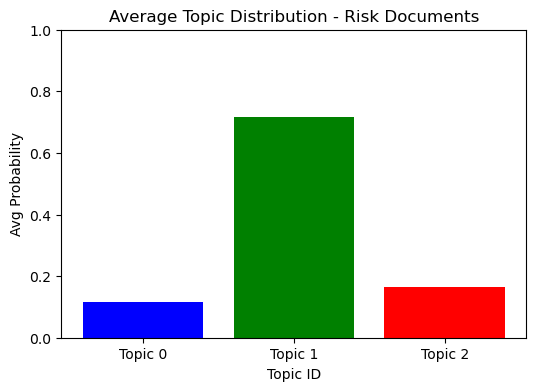

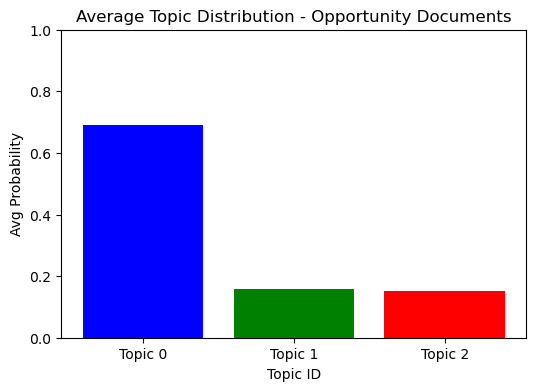

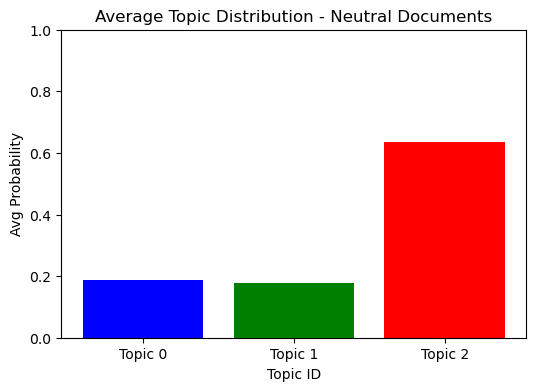

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# number of the topic districbution is  kept as 3 
num_topics = 3 
# adding the BoW vectors into the validation dataa for each document
val_topic_df["bow"] = val_df["tokens"].apply(lambda tokens: dictionary.doc2bow(tokens))

#  average topic distribution per predicted label
def get_mean_topic_distribution_by_label(topic_df, lda_model, num_topics):
    mean_distributions = {}
    for label in topic_df["Topic Label"].unique():
        label_rows = topic_df[topic_df["Topic Label"] == label]
        theta_vectors = []
        for bow in label_rows["bow"]:
            theta = lda_model[bow]
            dense_vector = np.zeros(num_topics)
            for topic_id, prob in theta:
                dense_vector[topic_id] = prob
            theta_vectors.append(dense_vector)
        mean_distributions[label] = np.mean(theta_vectors, axis=0)
    return mean_distributions
# average topic distributions
mean_distributions = get_mean_topic_distribution_by_label(val_topic_df, lda_model, num_topics)

# Plotting each label's average topic distribution
for label, dist in mean_distributions.items():
    plt.figure(figsize=(6, 4))
    plt.bar(range(num_topics), dist, tick_label=[f"Topic {i}" for i in range(num_topics)], color=["blue", "green", "red"])
    plt.title(f"Average Topic Distribution - {label} Documents")
    plt.xlabel("Topic ID")
    plt.ylabel("Avg Probability")
    plt.ylim(0, 1)
    plt.show()

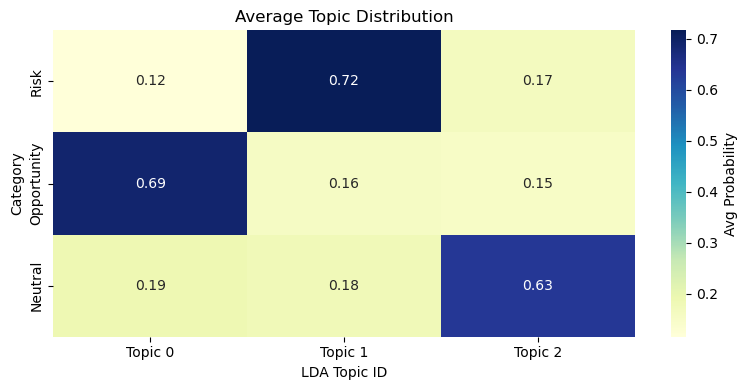

In [20]:
# commbining the topic ditributions mean into a single matrix
heatmap_data = np.vstack([
    mean_distributions["Risk"],
    mean_distributions["Opportunity"],
    mean_distributions["Neutral"]
])

# plotting the heatmap for the topics
plt.figure(figsize=(8, 4))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap="YlGnBu",
    xticklabels=[f"Topic {i}" for i in range(3)],
    yticklabels=["Risk", "Opportunity", "Neutral"],
    cbar_kws={'label': 'Avg Probability'}
)
plt.title("Average Topic Distribution")
plt.xlabel("LDA Topic ID")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

In [21]:
# validation datset index 25 
val_idx = 25
# raw and preprocessed tokens
val_text = val_df["text"].iloc[val_idx]
val_tokens = val_df["tokens"].iloc[val_idx]
print("RAW TEXT:\n")
print(val_text)
print("\n")

# tokens coverted into BoW using the training dictionary
val_bow_vector = dictionary.doc2bow(val_tokens)
print("BAG-OF-WORDS REPRESENTATION:\n")
for idx, count in val_bow_vector:
    print(f"{dictionary[idx]}: {count}")
dense_vec = np.zeros(len(dictionary))
for idx, count in val_bow_vector:
    dense_vec[idx] = count

RAW TEXT:

An additional 15 head counts are spread into the Group's business units acting as entry points for Corporate Social Responsibility issues across the Group's 3 pillars of Global Banking and Investor Solutions, French Retail Banking, and International Retail Banking and Financial Services.


BAG-OF-WORDS REPRESENTATION:

social: 1
additional: 1
unit: 1
corporate: 1
service: 1
business: 1
investor: 1
across: 1
financial: 1
group: 2
global: 1
issue: 1
responsibility: 1
international: 1
head: 1
spread: 1
solution: 1
point: 1
entry: 1
banking: 3
retail: 2
french: 1
acting: 1


In [22]:
# another document with index =45 
doc_idx_2 = 45

text_2 = val_df["text"].iloc[doc_idx_2]
tokens_2 = val_df["tokens"].iloc[doc_idx_2]
print("DOCUMENT 2:\n", text_2, "\n")
bow_2 = dictionary.doc2bow(tokens_2)

print("\nBoW for DOCUMENT 2:\n")
for idx, count in bow_2:
    print(f"{dictionary[idx]}: {count}")
dense_2 = np.zeros(len(dictionary))
for idx, count in bow_2:
    dense_2[idx] = count

DOCUMENT 2:
 Based on the information provided by the business delivery teams and the work of the Environment and Sustainability Department, Risk Management: - provides an independent assessment of risks associated with individual investments undertaken by the EBRD - performs an ongoing review of the portfolio to monitor the risks presented by investments from inception to repayment or exit, and - assesses and proposes ways to manage risks arising from correlations and concentrations within the portfolio. 


BoW for DOCUMENT 2:

department: 1
investment: 2
provided: 1
associated: 1
individual: 1
risk: 4
based: 1
arising: 1
assessment: 1
business: 1
environment: 1
delivery: 1
management: 1
manage: 1
performs: 1
review: 1
sustainability: 1
team: 1
concentration: 1
portfolio: 2
information: 1
way: 1
provides: 1
within: 1
work: 1
repayment: 1
exit: 1
monitor: 1
ebrd: 1
ongoing: 1
assesses: 1
proposes: 1
presented: 1
undertaken: 1
independent: 1


In [23]:
# for 3rd documnet with index = 55
doc_idx_3 = 55
text_3 = val_df["text"].iloc[doc_idx_3]
tokens_3 = val_df["tokens"].iloc[doc_idx_3]
print("DOCUMENT 3:\n", text_3, "\n")
bow_3 = dictionary.doc2bow(tokens_3)
print("\nBoW for DOCUMENT 3:\n")
for idx, count in bow_3:
    print(f"{dictionary[idx]}: {count}")

dense_3 = np.zeros(len(dictionary))

for idx, count in bow_3:
    dense_3[idx] = count

DOCUMENT 3:
 3) Active Ownership: engagement and voting activities We actively engage with companies to foster their efforts in aligning with a below 2 C world in pillar 3. We see engagement as a dialogue between investors and companies with the dual objective of impacting how companies operate and enhancing shareholder returns. Overall, around 36.8% of our direct company dialogues related partially or solely to climate change topics in 2019. In addition, Bank J. Safra Sarasin contributes to different collaborative engagement initiatives. For example, the Bank continued to par- ticipate in the Investor Decarbonisation Initiative led by ShareAction. Our full Active Ownership strategy is described below and is also outlined in our publicly available Active Ownership Policy and Active Ownership reports. 


BoW for DOCUMENT 3:

see: 1
change: 1
climate: 1
strategy: 1
also: 1
initiative: 2
addition: 1
different: 1
company: 4
investor: 2
report: 1
shareholder: 1
related: 1
aligning: 1
decarb

TF-IDF vector representation for all 3 docs with random indexes

In [24]:
from gensim.models import TfidfModel

# fitting the TF-IDF model on the training BoW represented words
tfidf_model = TfidfModel(bow_corpus)

# the 3 validation documents by index
idx_doc1 = 25
idx_doc2 = 45
idx_doc3 = 60

# Converting the validation tokens to BoW vectors
bow_doc1 = dictionary.doc2bow(val_df["tokens"].iloc[idx_doc1])
bow_doc2 = dictionary.doc2bow(val_df["tokens"].iloc[idx_doc2])
bow_doc3 = dictionary.doc2bow(val_df["tokens"].iloc[idx_doc3])

# Applying the TF-IDF model to get sparse vectors
tfidf_idx_doc1 = tfidf_model[bow_doc1]
tfidf_idx_doc2 = tfidf_model[bow_doc2]
tfidf_idx_doc3 = tfidf_model[bow_doc3]

# printing the TF-IDF vectirs for the documents we defined
print(f"\nTF-IDF vector for document 1 (index {idx_doc1}):")
print(tfidf_idx_doc1)
print(f"\nTF-IDF vector for document 2 (index {idx_doc2}):")
print(tfidf_idx_doc2)
print(f"\nTF-IDF vector for document 3 (index {idx_doc3}):")
print(tfidf_idx_doc3)



TF-IDF vector for document 1 (index 25):
[(38, 0.09820260846172461), (93, 0.15075911046059662), (117, 0.1761880051302661), (124, 0.1138724230550104), (139, 0.1138724230550104), (151, 0.06400086169349402), (209, 0.13009850504333537), (231, 0.11308824188848353), (273, 0.0817407514286223), (280, 0.16647842650023298), (363, 0.0889502943340295), (470, 0.1138724230550104), (486, 0.16411903135303907), (596, 0.14375077883257573), (649, 0.1882569789074931), (789, 0.25135674214927567), (904, 0.13774734485186485), (1244, 0.17983834739267546), (1605, 0.28043597908135454), (1653, 0.5091630096549745), (1705, 0.39760048030080736), (1740, 0.2222775052171968), (4514, 0.28043597908135454)]

TF-IDF vector for document 2 (index 45):
[(8, 0.16821946223197015), (21, 0.13905931829416393), (32, 0.1357375992559085), (44, 0.11353464639596686), (56, 0.1650133463284148), (66, 0.17763021644163385), (75, 0.115276445405647), (148, 0.18446039372000098), (149, 0.1253428613069013), (151, 0.061106262758932925), (159, 0

Convert sparse TF-IDF vectors to dense format

In [25]:
# initializing zero arrays with the size of the dictionary
doc1_tfidf_vec = np.zeros(len(dictionary))
for idx, val in tfidf_idx_doc1:
    doc1_tfidf_vec[idx] = val
doc2_tfidf_vec = np.zeros(len(dictionary))
for idx, val in tfidf_idx_doc2:
    doc2_tfidf_vec[idx] = val
doc3_tfidf_vec = np.zeros(len(dictionary))
for idx, val in tfidf_idx_doc3:
    doc3_tfidf_vec[idx] = val

In [26]:
def cossim(vec1, vec2):
    dot = np.dot(vec1, vec2)
    norm = np.linalg.norm(vec1) * np.linalg.norm(vec2)
    return dot / norm if norm != 0 else 0

In [27]:
sim1 = cossim(doc1_tfidf_vec, doc2_tfidf_vec)
sim2 = cossim(doc1_tfidf_vec, doc3_tfidf_vec)
print(f"\nCosine similarity btw (doc {idx_doc1}) and (doc {idx_doc2}): {sim1:.4f}")
print(f"Cosine similarity btw (doc {idx_doc1}) and (doc {idx_doc2}): {sim2:.4f}")


Cosine similarity btw (doc 25) and (doc 45): 0.0039
Cosine similarity btw (doc 25) and (doc 45): 0.0000


Cosine Similarity on LDA Topic Distributions

In [ ]:
# topic vectors from the LDAmodel for the 3 docs 
lda_vec_doc1 = lda_model[dictionary.doc2bow(val_df["tokens"].iloc[idx_doc1])]
lda_vec_doc2 = lda_model[dictionary.doc2bow(val_df["tokens"].iloc[idx_doc2])]
lda_vec_doc3 = lda_model[dictionary.doc2bow(val_df["tokens"].iloc[idx_doc3])]

# Converting to dense formats
def to_dense(theta, num_topics=3):
    dense = np.zeros(num_topics)
    for topic_id, prob in theta:
        dense[topic_id] = prob
    return dense
vec_1 = to_dense(lda_vec_doc1)
vec_2 = to_dense(lda_vec_doc2)
vec_3 = to_dense(lda_vec_doc3)

# Cosine similarities using LDA topic vectors
print("Using LDA topic distribution:")
print(f"document 1  vs  document 2: {cossim(vec_1, vec_2):.4f}")
print(f"document 1 vs document 3: {cossim(vec_1, vec_3):.4f}")

Using LDA topic distribution:
document 1  vs  document 2: 0.9833
document 1 vs document 3: 0.3622


Term-Document Matrix and Word Embeddings

In [29]:
# usinf the word embeddings 
# used CountVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(val_df["text"]) 
term_doc_mat = vectorizer.transform(val_df["text"]).T
print(term_doc_mat.shape)

(2652, 200)


Compare Word Similarities (examples taken 'climate' - neutral , 'sustainability' - opportunity, 'carbon' - risk)

In [30]:
def get_term_vector(vectorizer, term_doc_mat, word):
    index = vectorizer.vocabulary_[word]
    return term_doc_mat[index].toarray().flatten()
v1 = get_term_vector(vectorizer, term_doc_mat, 'climate')
v2 = get_term_vector(vectorizer, term_doc_mat, 'sustainability')
v3 = get_term_vector(vectorizer, term_doc_mat, 'carbon')
print("climate vs sustainability:", cossim(v1, v2))
print("climate vs carbon:", cossim(v1, v3))

climate vs sustainability: 0.1801801801801802
climate vs carbon: 0.19951067739032335


Word2Vec on the climate tokens

In [31]:
from gensim.models import Word2Vec
tokenized = val_df["tokens"].tolist()
w2v_model = Word2Vec(sentences=tokenized, sg=1, window=3, min_count=1, vector_size=100)
print(w2v_model.wv.similar_by_word("climate", topn=5))

[('risk', 0.9813060760498047), ('investment', 0.9811582565307617), ('business', 0.9784637093544006), ('company', 0.9753931760787964), ('project', 0.9752494096755981)]


In [32]:
# word embeddings - glove twitter 
import gensim.downloader as api
glove = api.load("glove-twitter-25")
glove.similar_by_word("climate", topn=5)

[('economic', 0.9249215126037598),
 ('environmental', 0.903428316116333),
 ('inequality', 0.889825165271759),
 ('democracy', 0.8856668472290039),
 ('poverty', 0.8839098215103149)]

HDP Modelling 

In [37]:
from gensim.corpora import Dictionary
from gensim.models import HdpModel
#  climate tokens 
climate_tokens = val_df["tokens"].tolist()  
# dictionary and Bow for climate tokens
climate_dict = Dictionary(climate_tokens)
climate_bow = [climate_dict.doc2bow(doc) for doc in climate_tokens]
#HDP modelling on this data
hdp_model = HdpModel(climate_bow, id2word=climate_dict, alpha=0.01, gamma=0.01)

In [38]:
for idx, topic in hdp_model.print_topics(3):
    print(f"Topic {idx}:\n{topic}\n")

Topic 0:
0.004*proprietary + 0.003*reliability + 0.003*due + 0.003*product + 0.003*pko + 0.003*eventual + 0.003*combine + 0.003*outsized + 0.003*eur + 0.002*debt

Topic 1:
0.003*hydrocarbon + 0.003*implicit + 0.003*johan + 0.003*kaplan + 0.003*survey + 0.002*leader + 0.002*multiple + 0.002*example + 0.002*added + 0.002*tsunami

Topic 2:
0.004*scope + 0.003*throughout + 0.003*date + 0.003*influence + 0.003*adaptation + 0.003*variable + 0.003*calculation + 0.002*regulation + 0.002*software + 0.002*focusing



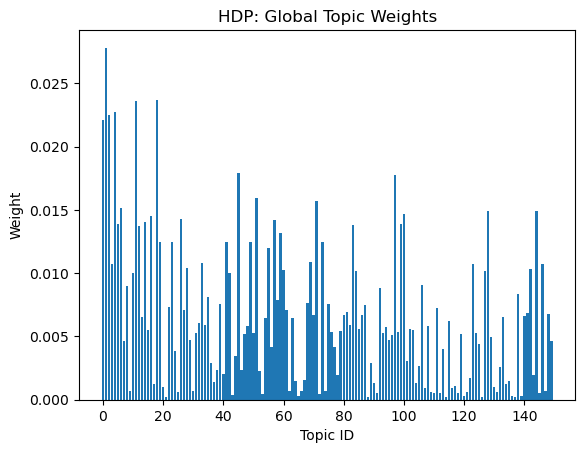

In [39]:
# plotting the HDP modelling with topic with its weights
def plot_global_topic_weights(hdp_model):
    global_topic_weights = hdp_model.m_varphi_ss / np.sum(hdp_model.m_varphi_ss)
    plt.bar(np.arange(len(global_topic_weights)), global_topic_weights)
    plt.title("HDP: Global Topic Weights")
    plt.xlabel("Topic ID")
    plt.ylabel("Weight")
    plt.show()
plot_global_topic_weights(hdp_model)


Topic 0 labeled as **OPPORTUNITY**:
Top words: energy, emission, carbon, project, million, target, gas, climate, year, also, business, green, renewable, new, finance

Topic 1 labeled as **RISK**:
Top words: risk, climate, change, impact, environmental, may, physical, investment, business, emission, management, group, social, also, transition

Topic 2 labeled as **RISK**:
Top words: carbon, risk, investment, company, energy, project, climate, portfolio, power, asset, new, emission, oil, scenario, group


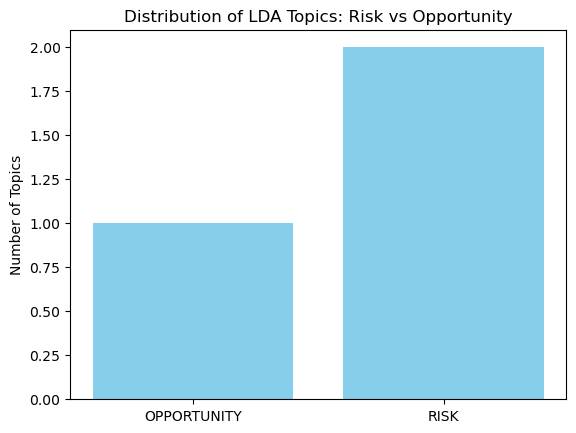

In [40]:
# Final Summary: Label LDA Topics as “Risks” vs “Opportunities” which is necessary for the task 
# we are defining a few words or tokebs for risk abd opportunities
risk_keywords = ['risk', 'hazard', 'loss', 'pollution', 'flood', 'drought', 'disaster', 'damage', 'climate', 'emission', 'co2', 'impact']
opportunity_keywords = ['solution', 'policy', 'innovation', 'green', 'sustainable', 'renewable', 'investment', 'energy', 'growth', 'benefit']
num_topics = lda_model.num_topics

topic_labels = []
for i in range(num_topics):
    topic_words = lda_model.show_topic(i, topn=15)
    topic_terms = [word for word, _ in topic_words]
    
    risk_score = sum(1 for word in topic_terms if word.lower() in risk_keywords)
    opp_score = sum(1 for word in topic_terms if word.lower() in opportunity_keywords)
    
    if risk_score > opp_score:
        label = "RISK"
    elif opp_score > risk_score:
        label = "OPPORTUNITY"
    else:
        label = "NEUTRAL"
    
    topic_labels.append((i, label, topic_terms))

# labelled topics
for topic_id, label, terms in topic_labels:
    print(f"\nTopic {topic_id} labeled as **{label}**:")
    print("Top words:", ", ".join(terms))

# Visualise distribution of labels (optional)
import matplotlib.pyplot as plt
from collections import Counter

label_counts = Counter([label for _, label, _ in topic_labels])
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.title("Distribution of LDA Topics: Risk vs Opportunity")
plt.ylabel("Number of Topics")
plt.show()

In [75]:

risk_keywords = ["disaster", "flood", "damage", "loss", "vulnerability", "pollution", "carbon"]
opportunity_keywords = ["innovation", "technology", "solution", "policy", "investment", "growth", "renewable"]

risk_topics = []
opportunity_topics = []

for idx, topic in lda_model.print_topics(-1):
    topic_words = topic.lower()
    if any(word in topic_words for word in risk_keywords):
        risk_topics.append((idx, topic))
    elif any(word in topic_words for word in opportunity_keywords):
        opportunity_topics.append((idx, topic))

print("RISK-RELATED TOPICS:")
for t in risk_topics:
    print(t)

print("\nOPPORTUNITY-RELATED TOPICS:")
for t in opportunity_topics:
    print(t)


RISK-RELATED TOPICS:
(0, '0.015*"energy" + 0.013*"emission" + 0.009*"carbon" + 0.008*"project" + 0.007*"million" + 0.007*"target" + 0.007*"gas" + 0.006*"climate" + 0.006*"year" + 0.006*"also"')
(2, '0.009*"carbon" + 0.008*"risk" + 0.008*"investment" + 0.008*"company" + 0.008*"energy" + 0.008*"project" + 0.007*"climate" + 0.007*"portfolio" + 0.006*"power" + 0.006*"asset"')

OPPORTUNITY-RELATED TOPICS:
(1, '0.034*"risk" + 0.022*"climate" + 0.019*"change" + 0.012*"impact" + 0.008*"environmental" + 0.007*"may" + 0.007*"physical" + 0.006*"investment" + 0.006*"business" + 0.006*"emission"')
